# Intro to reimbursements: overview with visualization

This notebook provides an overview of the `2017-03-15-reimbursements.xz` dataset, which contains broad data regarding CEAP usage in all terms since 2009. 

It aims to provide an example of basic analyses and visualization by exploring topics such as:

- Average monthly spending per congressperson along the years
- Seasonality in reimbursements
- Reimbursements by type of spending
- Which party has the most spending congressmen?
- Which state has the most spending congressmen?
- Who were the most hired suppliers by amount paid?
- Which were the most expensive individual reimbursements?

Questions are not explicitly answered. Charts and tables are provided for free interpretation, some of them with brief commentaries from the author.

**Obs**.: original analysis was made considering data from 2009 to 2017 (mainly until 2016). One might want to filter by terms (e.g. 2010-2014) to make more realistic comparisons (spenditures by state, party, congressperson, etc.). Code cell #4 provides an example of how it could be done.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams

%matplotlib inline

# Charts styling
plt.style.use('ggplot')
rcParams['figure.figsize'] = 15, 8
matplotlib.rcParams.update({'font.size': 14})
#rcParams['font.family'] = 'Georgia'

# Type setting for specific columns
#DTYPE = dict(cnpj=np.str, cnpj_cpf=np.str, ano=np.int16, term=np.str)

# Experimenting with 'category' type to reduce df size
DTYPE =dict(cnpj_cpf=np.str,\
            year=np.int16,\
            month=np.int16,\
            installment='category',\
            term_id='category',\
            term='category',\
            document_type='category',\
            subquota_group_id='category',\
            subquota_group_description='category',\
            #subquota_description='category',\
            subquota_number='category',\
            state='category',\
            party='category')

In [2]:
reimbursements = pd.read_csv('../data/2017-03-15-reimbursements.xz', \
                             dtype=DTYPE, low_memory=False, parse_dates=['issue_date'])

In [3]:
# Creates a DataFrame copy with fewer columns
r = reimbursements[['year', 'month', 'total_net_value', 'party', 'state', 'term', 'issue_date',\
        'congressperson_name', 'subquota_description','supplier', 'cnpj_cpf']]
r.head()

,year,month,total_net_value,party,state,term,issue_date,congressperson_name,subquota_description,supplier,cnpj_cpf
0,2009,4,130.00,PP,PR,2015.0,2009-04-06 00:00:00.0,DILCEU SPERAFICO,Fuels and lubricants,MELHOR POSTO DE COMBUSTÍVEIS LTDA,02989654001197
1,2009,4,135.00,PP,PR,2015.0,2009-04-07 00:00:00.0,DILCEU SPERAFICO,"Locomotion, meal and lodging",MELONGENA PARTICIPAÇÕES LTDA,09259358000450
2,2009,3,1000.00,PP,PR,2015.0,2009-03-12 00:00:00.0,DILCEU SPERAFICO,Maintenance of office supporting parliamentary...,ARY ANTONIO MOSCHETTA,01537369920
3,2009,4,170.00,PP,PR,2015.0,2009-04-14 00:00:00.0,DILCEU SPERAFICO,Fuels and lubricants,CONVER COMBUSTÍVEIS AUTOMÓVEIS LTDA,00038505000579
4,2009,4,100.11,PP,PR,2015.0,2009-04-09 00:00:00.0,DILCEU SPERAFICO,Fuels and lubricants,GRANDO E GROFF LTDA,00161576000211


## Filters depending on the scope of analysis
Here, filters by state, party, years, etc. can be applied.

Obs.: chart commentaries provided might not remain valid depending on filters chosen. 

In [4]:
# Filters only most recent years (from 2015)
#r = r[(r.year == 2015) | (r.year == 2016) | (r.year == 2017)]

#r.head()

## Questions & answers

### Evolution of average monthly spending along the years
Are congressmen spending more today in relation to past years?

#### How many congressmen in each year?

In [5]:
years = r.year.unique()

# Computes unique names in each year and saves into a pd.Series
d = dict()
for y in years:
    d[y] = r[r.year == y].congressperson_name.nunique()

s = pd.Series(d)
s

2009    537
2010    546
2011    778
2012    560
2013    544
2014    564
2015    769
2016    573
2017    520
dtype: int64

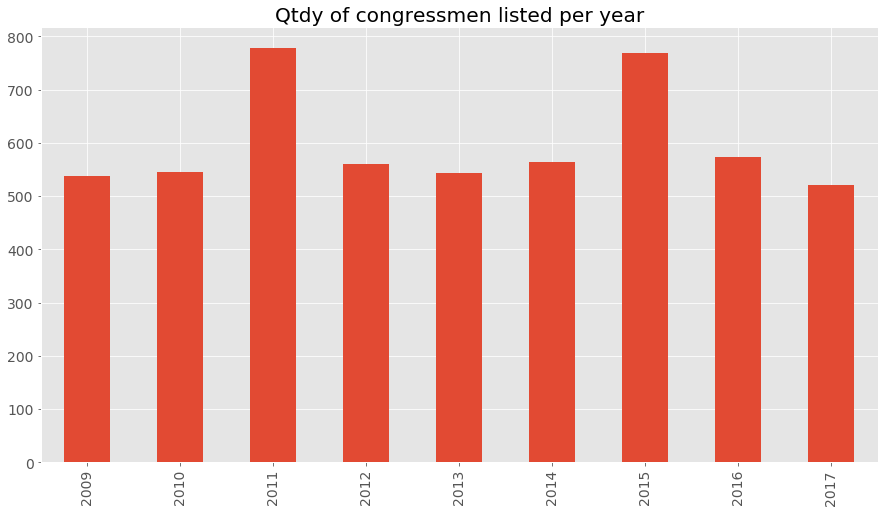

In [6]:
s.plot(kind='bar')
plt.title('Qtdy of congressmen listed per year')

##### Commentary
Greater number of congressmen in 2011 and 2015 is due to term transitions which occur during the year.

---

#### How much did they spend, in average, per month in each year?
This analysis takes into consideration the following elements:

- Main data: 
    - Monthly average spending per congressman during each year
- Relevant aspects for trend comparison:
    - CEAP limit for each year (i.e. the maximum allowed quota increased during the years)
    - Inflation indexes (i.e. prices of goods raised during the years)

##### Evolution of inflation (IPCA)

In [7]:
# Source: http://www.ibge.gov.br/home/estatistica/indicadores/precos/inpc_ipca/defaultseriesHist.shtm
ipca_years = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]  
ipca_indexes = [0.0431, 0.0590, 0.0650, 0.0583, 0.0591, 0.0641, 0.1067, 0.0629]

ipca = pd.DataFrame({
    'year': ipca_years,
    'ipca': ipca_indexes
})


# Filters only by years in dataset
ipca = ipca[ipca['year'].isin(r.year.unique())].set_index('year')
ipca.head()

,ipca
year,
2009,0.0431
2010,0.0590
2011,0.0650
2012,0.0583
2013,0.0591


##### Maximum quota allowed (CEAP limits)
There is information available for maximum CEAP for 2009 and 2017. Therefore, a simple compound growth rate (CAGR) is calculated from 2009 to 2017. Values for years in between are assumed to be a linear composition of the growth rate.

In [8]:
states = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG', 'MS', 'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR', 'RS', 'SC', 'SE', 'SP', 'TO']

# Source: http://www2.camara.leg.br/a-camara/estruturaadm/diretorias/dirgeral/estrutura-1/deapa/portal-da-posse/ceap-1
ceap_2009 = [40711.32, 37318.73, 39734.17, 39554.50, 35540.51, 38705.50, 27977.66, 34080.83, 32317.69, 38429.49, 32856.38, 36949.65, 35924.24, 38499.17, 38319.91, 37992.68, 37344.18, 35412.67, 32550.32, 38963.25, 39828.33, 41612.80, 37256.00, 36337.92, 36578.43, 33730.95, 35993.76]

# Source: http://www2.camara.leg.br/comunicacao/assessoria-de-imprensa/cota-parlamentar
ceap_2017 = [44632.46, 40944.10, 43570.12, 43374.78, 39010.85, 42451.77, 30788.66, 37423.91, 35507.06, 42151.69, 36092.71, 40542.84, 39428.03, 42227.45, 42032.56, 41676.80, 40971.77, 38871.86, 35759.97, 42731.99, 43672.49, 45612.53, 40875.90, 39877.78, 40139.26, 37043.53, 39503.61]

ceap_limit_states = pd.DataFrame({
    'ceap_2009': ceap_2009,
    'ceap_2017': ceap_2017
}, index=states)

ceap_limit_states.head()

,ceap_2009,ceap_2017
AC,40711.32,44632.46
AL,37318.73,40944.10
AM,39734.17,43570.12
AP,39554.50,43374.78
BA,35540.51,39010.85


In [9]:
all_years = ipca_years

# Calculates CAGR according to data available (CEAP@2009 and CEAP@2017), using the CEAP average among states
cagr = ((ceap_limit_states.ceap_2017.mean() / ceap_limit_states.ceap_2009.mean())**(1./(2017-2009)) - 1)

# Computes estimated CEAP values for years in between 2009 and 2017 using CAGR
ceap_values = []
for i in range(2017-2009):
    if i == 0:
        ceap_values.append(ceap_limit_states.ceap_2009.mean())
    elif i == (r.year.nunique() - 1):
        ceap_values.append(ceap_limit_states.ceap_2017.mean())
    else:
        ceap_values.append(ceap_values[i-1] * (1 + cagr))
        
# Creates df with all years
ceap_limit_years = pd.DataFrame({
    'year': all_years,
    'max_avg_ceap': ceap_values
})

# Filters only by years in dataset
ceap_limit_years = ceap_limit_years[ceap_limit_years['year'].isin(r.year.unique())].set_index('year')
ceap_limit_years.head()

,max_avg_ceap
year,
2009,36685.964444
2010,37114.319272
2011,37547.675681
2012,37986.092072
2013,38429.627527


In [10]:
# Groups by name summing up spendings
a = r.groupby(['year']).sum().drop('month', 1)
a['congressmen_qty'] = s
a['avg_monthly_value_per_congressmen'] = a['total_net_value'] / a['congressmen_qty'] / 12
a = a.drop(2017, 0)  # Neglets 2017

# Adds columns for CEAP limits and IPCA indexes
a['max_avg_ceap'] = ceap_limit_years['max_avg_ceap']
a['pct_of_quota_used'] = (a['avg_monthly_value_per_congressmen'] / a['max_avg_ceap']) * 100
a['ipca'] = ipca['ipca']
a['acc_ipca'] = (a['ipca'] + 1).cumprod() - 1
a

,total_net_value,congressmen_qty,avg_monthly_value_per_congressmen,max_avg_ceap,pct_of_quota_used,ipca,acc_ipca
year,,,,,,,
2009,9.078889e+07,537,14088.902291,36685.964444,38.404067,0.0431,0.043100
2010,1.203424e+08,546,18367.270725,37114.319272,49.488368,0.0590,0.104643
2011,1.237837e+08,778,13258.747373,37547.675681,35.311766,0.0650,0.176445
2012,1.227342e+08,560,18264.010670,37986.092072,48.080783,0.0583,0.245031
2013,1.309542e+08,544,20060.388283,38429.627527,52.200319,0.0591,0.318613
2014,1.410440e+08,564,20839.839214,38878.341816,53.602696,0.0641,0.403136
2015,1.568238e+08,769,16994.347939,39332.295409,43.207109,0.1067,0.552850
2016,1.651688e+08,573,24021.056838,39791.549483,60.367232,0.0629,0.650525


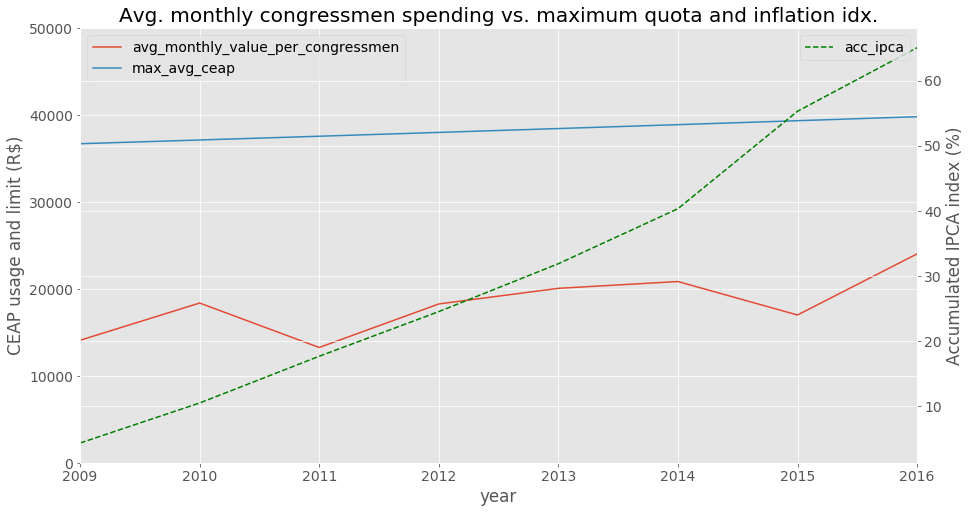

In [11]:
# Procedure to handle secondary Y axis
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()

y0 = a[['avg_monthly_value_per_congressmen', 'max_avg_ceap']].plot(kind='line', ax=ax0)#, label='Itens vendidos')
y1 = (a['acc_ipca']*100).plot(kind='line', secondary_y=False, style='g--', ax=ax1)#, label='Preço unitário')
y0.legend(loc=2) # bar legend to the left
y1.legend(loc=1) # line legend to the right

y0.set_ylim((0,50000))
#y1.set_ylim((0,50000))
y0.set_ylabel('CEAP usage and limit (R$)')
y1.set_ylabel('Accumulated IPCA index (%)')

plt.title('Avg. monthly congressmen spending vs. maximum quota and inflation idx.')
plt.show()
plt.close()

##### Commentary
Although average spending has increased along the years, it can be due to both aspects considered: raises in prices and expanded limit for reimbursements.

The next chart shows how spending has increased with respect to quota limits.

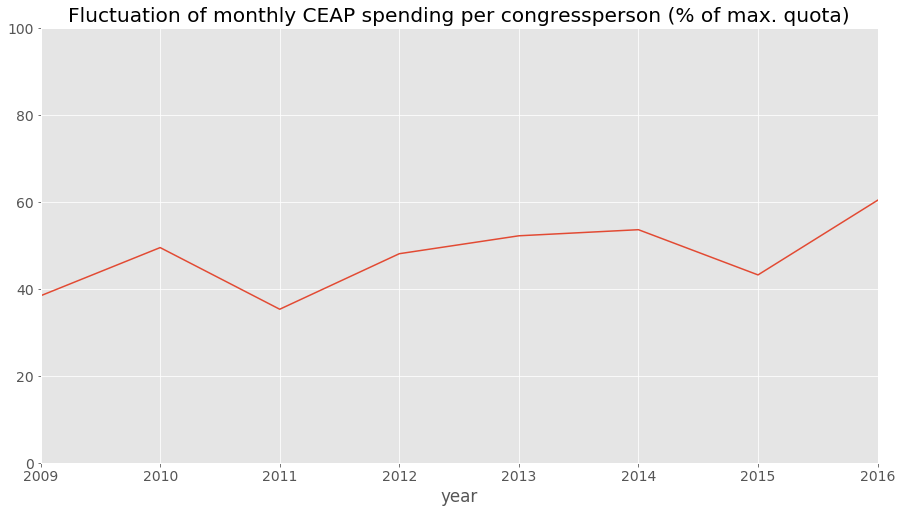

In [12]:
a.pct_of_quota_used.plot()
plt.ylim((0,100))
plt.title('Fluctuation of monthly CEAP spending per congressperson (% of max. quota)')

##### Commentary
The chart shows that average spending has increased more than quota limits were raised (from ca. 40% to 60% of quota usage). This might be due to the steep rise in inflation levels, as observed in the previous chart.

---

### Average monthly spending per congressperson along the years
This table shows the data above detailed per congressperson.

In [13]:
# Groups by name summing up spendings
a = r.groupby(['congressperson_name', 'year'])\
    .sum()\
    .drop('month', 1)

# Computes average spending per month and unstacks
a['monthly_total_net_value'] = a['total_net_value'] / 12
a = a.drop('total_net_value', 1).unstack()

# Creates subtotal column to the right
a['mean'] = a.mean(axis=1)

a.head()

monthly_total_net_value                            \
year                                   2009        2010          2011   
congressperson_name                                                     
ABEL MESQUITA JR.                       NaN         NaN           NaN   
ABELARDO CAMARINHA             14842.920833  23329.1400  13841.418333   
ABELARDO LUPION                18152.250000  21526.4125  23267.983333   
ACELINO POPÓ                            NaN         NaN  20218.460833   
ACÁCIO JÚNIOR                           NaN         NaN    764.000000   

                                                                             \
year                         2012          2013          2014          2015   
congressperson_name                                                           
ABEL MESQUITA JR.             NaN           NaN           NaN  32626.218333   
ABELARDO CAMARINHA   21381.600000  24442.093333  27206.505833   2693.010833   
ABELARDO LUPION      22145.420000  22246.507500  27486.450000   2497.000000   
ACELINO POPÓ         23457.991667  24405.267500  23608.119167   2604.166667   
ACÁCIO JÚNIOR                 NaN           NaN           NaN           NaN   

                                                      mean  
year                       2016         2017                
congressperson_name                                         
ABEL MESQUITA JR.    37927.9375  1685.588333  24079.914722  
ABELARDO CAMARINHA          NaN          NaN  18248.098452  
ABELARDO LUPION             NaN          NaN  19617.431905  
ACELINO POPÓ                NaN          NaN  18858.801167  
ACÁCIO JÚNIOR               NaN          NaN    764.000000

### Seasonality in reimbursements
Out of curiosity,in which period of the year more reimbursements were issued?

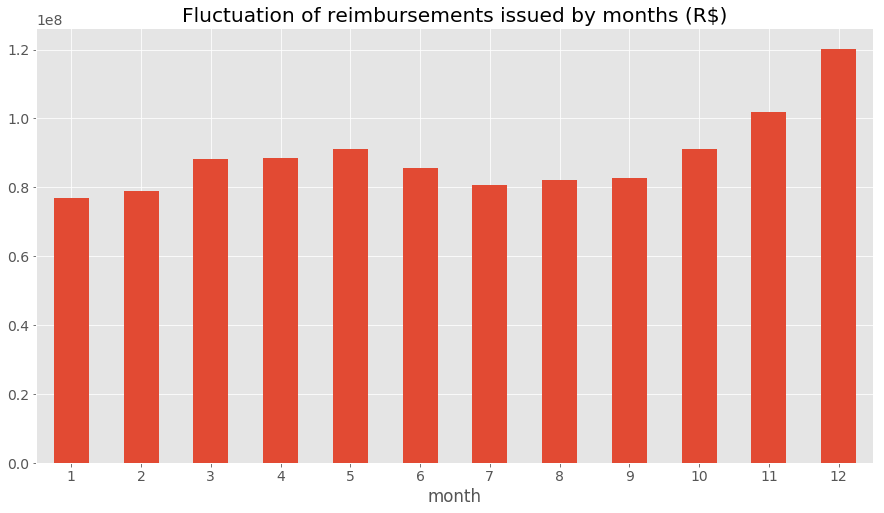

In [14]:
r.groupby('month')\
    .sum()\
    .total_net_value\
    .sort_index()\
    .plot(kind='bar', rot=0)
    
plt.title('Fluctuation of reimbursements issued by months (R$)')

### Reimbursements by type of spending
For what are congressmen most using their quota?

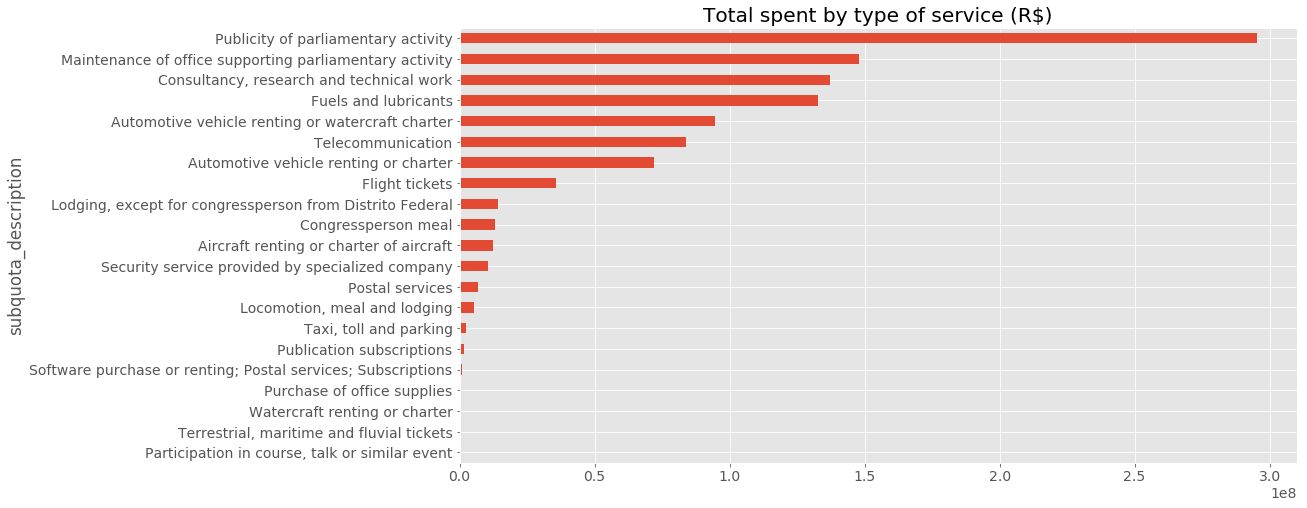

In [15]:
r.groupby('subquota_description')\
    .sum()\
    .total_net_value\
    .sort_values(ascending=True)\
    .plot(kind='barh')
    
plt.title('Total spent by type of service (R$)')

##### Commentary
This chart makes it clear what is prioritized by congressmen: publicity of their activity. Voters might judge whether this choice is reasonable or not.

---

### Which party has the most spending congressmen?

##### How many congressmen in each party?

In [16]:
parties = r.party.unique()
parties

[PP, SD, PMDB, PSDB, PDT, ..., REDE, PRP, NaN, PSDC, PRTB]
Length: 32
Categories (31, object): [PP, SD, PMDB, PSDB, ..., REDE, PRP, PSDC, PRTB]

In [17]:
# Computes unique names in each state and saves into a pd.Series
d = dict()
for p in parties:
    d[p] = r[r.party == p].congressperson_name.nunique()

s = pd.Series(d)
s

PP          82
SD          26
PMDB       179
PSDB       123
PDT         41
PTB         38
PT         156
PV          25
PSOL         8
PSD         67
PR          77
PSB         71
PSC         26
DEM         76
PCdoB       25
PRB         37
PHS          9
PPS         20
PEN          4
PTC          4
S.PART.      2
PTN         14
PSL          3
PROS        16
PMN          4
PTdoB        6
PMB          1
REDE         3
PRP          4
NaN          0
PSDC         1
PRTB         1
dtype: int64

#### How much did congressmen from each party spend in the year, in average? 

In [18]:
t = r.groupby('party').sum()
t = t.drop(['year', 'month'], 1)  # Removes useless columns

t['congressmen_per_party'] = s
years = r.year.nunique()

In [19]:
t['monthly_value_per_congressperson'] = t['total_net_value'] / t['congressmen_per_party'] / (12*years)
t.sort_values(by='monthly_value_per_congressperson', ascending=False).head()

,total_net_value,congressmen_per_party,monthly_value_per_congressperson
party,,,
PMB,1.661347e+06,1,15382.839630
SD,3.274392e+07,26,11660.940499
PSD,7.858506e+07,67,10860.289638
PEN,4.584585e+06,4,10612.464907
PTdoB,6.809836e+06,6,10509.006590


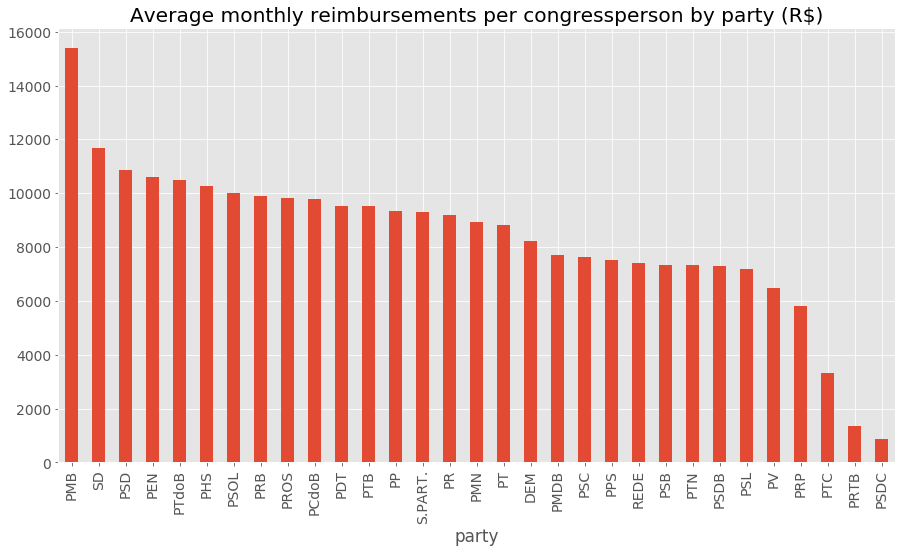

In [20]:
t.monthly_value_per_congressperson\
    .sort_values(ascending=False)\
    .plot(kind='bar')

plt.title('Average monthly reimbursements per congressperson by party (R$)')

##### Commentary
It is important to note that many congressmen change parties frequently. Therefore, anyone interested in drawing conclusions regarding parties might want to analyse the data in further detail than it is presented here.

---

### Which state has the most spending congressmen?

##### How many congressmen in each state?

In [21]:
states = r.state.unique()
states

[PR, MA, SC, RJ, MG, ..., SE, ES, RR, RN, NaN]
Length: 28
Categories (27, object): [PR, MA, SC, RJ, ..., SE, ES, RR, RN]

In [22]:
# Computes unique names in each party and saves into a pd.Series
d = dict()
for s in states:
    d[s] = r[r.state == s].congressperson_name.nunique()

s = pd.Series(d)
s

PR      64
MA      50
SC      36
RJ     108
MG     100
PA      38
RS      64
PE      52
SP     158
BA      83
CE      47
GO      35
PI      25
RO      20
PB      24
MT      22
MS      18
AP      17
AM      19
AC      19
AL      27
DF      20
TO      21
SE      22
ES      22
RR      22
RN      16
NaN      0
dtype: int64

#### How much did congressmen from each party spend in the year, in average? 

##### (!) Important: CEAP maximum value differs among states
As already commented previously, CEAP max. quota varies among state, according to: http://www2.camara.leg.br/comunicacao/assessoria-de-imprensa/cota-parlamentar, 

In [23]:
# CEAP maximum values from 2017
ceap_states = ceap_limit_states.drop('ceap_2009',1)
ceap_states.columns = ['monthly_max_ceap']  # Renames column to be compatible to code below
ceap_states.head()

,monthly_max_ceap
AC,44632.46
AL,40944.10
AM,43570.12
AP,43374.78
BA,39010.85


In [24]:
t = r.groupby('state').sum()
t = t.drop(['year', 'month'], 1)  # Removes useless columns

t['congressmen_per_state'] = s
t['monthly_max_ceap'] = ceap_states
years = r.year.nunique()

In [25]:
t['monthly_value_per_congressperson'] = t['total_net_value'] / t['congressmen_per_state'] / (12*years)
t['ceap_usage'] = (t['monthly_value_per_congressperson'] / t['monthly_max_ceap']) * 100

t.sort_values(by='ceap_usage', ascending=False).head()

,total_net_value,congressmen_per_state,monthly_max_ceap,monthly_value_per_congressperson,ceap_usage
state,,,,,
GO,3.781499e+07,35,35507.06,10003.966799,28.174585
MG,1.070329e+08,100,36092.71,9910.449465,27.458314
PB,2.824711e+07,24,42032.56,10897.803978,25.927053
AP,2.016225e+07,17,43374.78,10981.618115,25.317980
MS,1.971990e+07,18,40542.84,10143.983426,25.020407


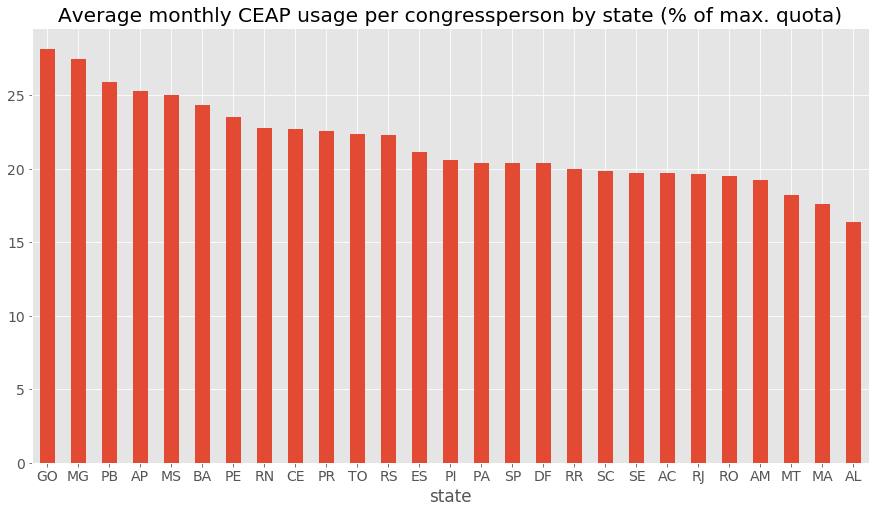

In [26]:
t.ceap_usage\
    .sort_values(ascending=False)\
    .plot(kind='bar', rot=0)

plt.title('Average monthly CEAP usage per congressperson by state (% of max. quota)')

#### Comparison between given state and the country's average

In [27]:
t.head()

,total_net_value,congressmen_per_state,monthly_max_ceap,monthly_value_per_congressperson,ceap_usage
state,,,,,
AC,18053592.34,19,44632.46,8798.046949,19.712216
AL,19534477.27,27,40944.10,6699.066279,16.361494
AM,17209534.32,19,43570.12,8386.712632,19.248771
AP,20162250.86,17,43374.78,10981.618115,25.317980
BA,85100611.85,83,39010.85,9493.597931,24.335788


In [28]:
country_average = t.ceap_usage.mean()
country_average

21.680250126969085

In [29]:
# Parametrizes single state analysis
state = 'SP'
state_average = t.loc[state].ceap_usage
state_average

20.409277149308839

In [30]:
s = pd.Series()
s['average_all_states'] = country_average
s[state] = state_average
s

average_all_states    21.680250
SP                    20.409277
dtype: float64

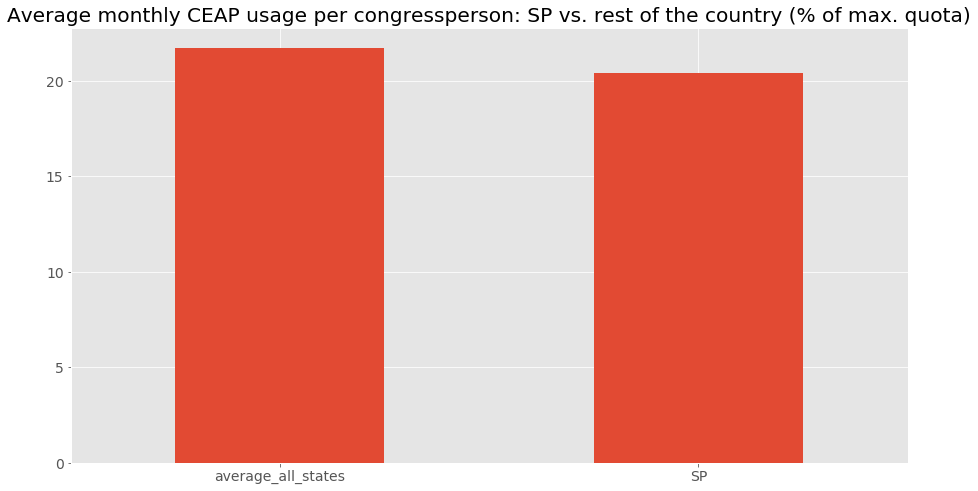

In [31]:
s.plot(kind='bar', rot=0)
plt.title('Average monthly CEAP usage per congressperson: ' + state + ' vs. rest of the country (% of max. quota)')

### Who were the top spenders of all time in absolute terms?

In [32]:
r.groupby('congressperson_name')\
    .sum()\
    .total_net_value\
    .sort_values(ascending=False)\
    .head(10)

congressperson_name
WELLINGTON ROBERTO         3004465.11
CLEBER VERDE               2895861.67
RAIMUNDO GOMES DE MATOS    2777134.46
EFRAIM FILHO               2740068.65
GORETE PEREIRA             2682520.94
RENATO MOLLING             2675980.13
SILAS CÂMARA               2616348.57
DÉCIO LIMA                 2596289.87
NELSON MEURER              2565541.34
HERMES PARCIANELLO         2544743.67
Name: total_net_value, dtype: float64

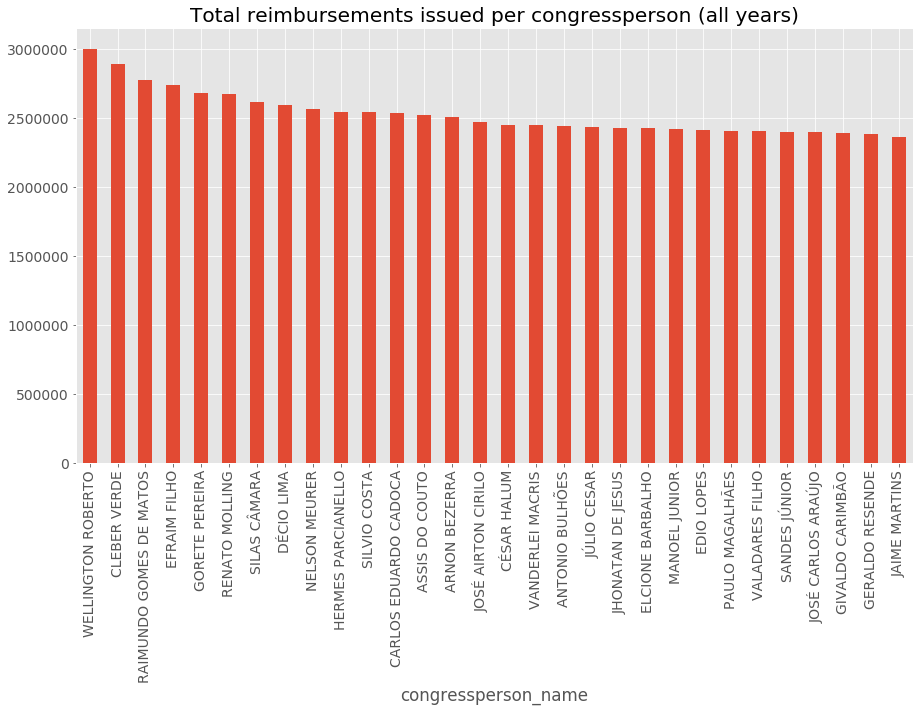

In [33]:
r.groupby('congressperson_name')\
    .sum()\
    .total_net_value\
    .sort_values(ascending=False)\
    .head(30)\
    .plot(kind='bar')

plt.title('Total reimbursements issued per congressperson (all years)')

##### Commentary
Because the dataset comprises 2009-2017, it might not be reasonable to draw any hard conclusions by looking to this chart alone. Some congressmen might have been elected for longer periods and that would reflect on higher reimbursement total values.

For a more detailed - hence coherent - analysis, one might want to make this comparison for each term (e.g. 2010-2014). That would better identify "top spenders" by comparing congressmen spendings on the same time period.

Another interesting analysis can be made by expanding the chart to all congressmen, not only the top 30. This enables a richer look at how discrepant top spenders are from the rest. To do that, just change `.head(30)\` argument in the previous cell.

---

### Who were the most hired suppliers by amount paid?
This analysis identifies suppliers by their unique CNPJ. It is worth noting that, commonly, some telecom carriers use different CNPJ for its subsidiaries in different states (e.g. TIM SP, TIM Sul, etc).

In [34]:
sp = r.groupby(['cnpj_cpf', 'supplier', 'subquota_description'])\
        .sum()\
        .drop(['year', 'month'], 1)\
        .sort_values(by='total_net_value', ascending=False)

sp.reset_index(inplace=True)  
sp = sp.set_index('cnpj_cpf')

sp.head()

,supplier,subquota_description,total_net_value
cnpj_cpf,,,
22005529000130,DOUGLAS CUNHA DA SILVA ME,"Consultancy, research and technical work",2886396.29
33000118000179,TELEMAR NORTE LESTE S/A,Telecommunication,2583254.49
04206050005140,TIM,Telecommunication,2528998.43
15193908000136,JOSELY FERNANDA DO NASCIMENTO,Publicity of parliamentary activity,2071565.06
13230334000101,InCine Video Ltda - ME,Publicity of parliamentary activity,1861070.00


In [35]:
cnpj = r.groupby('cnpj_cpf')\
        .sum()\
        .drop(['year', 'month'], 1)\
        .sort_values(by='total_net_value', ascending=False)

cnpj.head()

,total_net_value
cnpj_cpf,
02558157000162,1.708564e+07
04206050005140,7.991450e+06
33000118000179,4.744956e+06
66970229000167,4.311590e+06
02012862000160,3.457621e+06


In [36]:
# Adds supplier name besides total_net_value in cnpj df

cnpj['supplier'] = ''  # Creates empty column
cnpj = cnpj.head(1000)  # Gets only first 1000 for this analysis

In [37]:
# Looks up for supplier names in sp df and fills cnpj df (it might take a while to compute...)

for i in range(len(cnpj)):
    try:
        cnpj.set_value(cnpj.index[i], 'supplier', sp.loc[cnpj.index[i]].supplier.iloc[0])
    except:
        cnpj.set_value(cnpj.index[i], 'supplier', sp.loc[cnpj.index[i]].supplier)

cnpj.head(10)

,total_net_value,supplier
cnpj_cpf,,
02558157000162,1.708564e+07,TELEFONICA BRASIL S.A.
04206050005140,7.991450e+06,TIM
33000118000179,4.744956e+06,TELEMAR NORTE LESTE S/A
66970229000167,4.311590e+06,NEXTEL TELECOMUNICAÇÕES LTDA
02012862000160,3.457621e+06,TAM LINHAS AÉREAS.
22005529000130,2.975396e+06,DOUGLAS CUNHA DA SILVA ME
76535764000143,2.796699e+06,OI S.A.
02449992000164,2.749713e+06,VIVO S.A.
11842749000100,2.735355e+06,SERVIÇOS EXECUTIVOS RENT A CAR


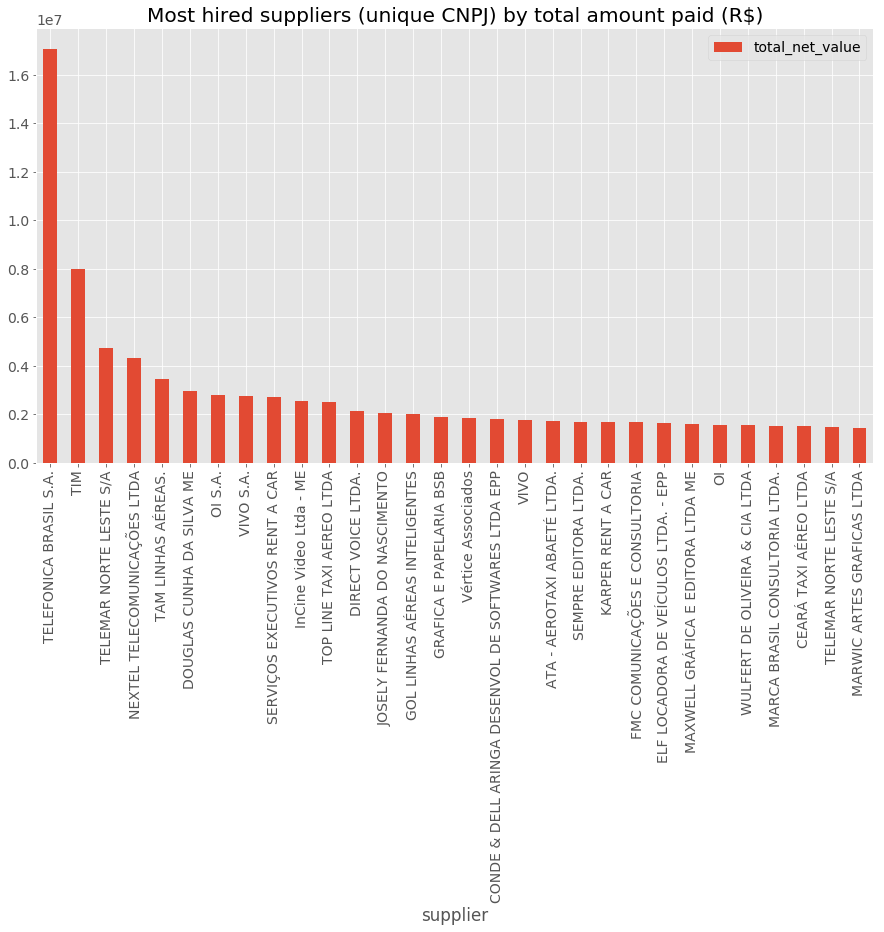

In [38]:
# Fixes better indexing to plot in a copy
sp2 = cnpj.set_index('supplier')

sp2.head(30)\
    .plot(kind='bar')

plt.title('Most hired suppliers (unique CNPJ) by total amount paid (R$)')

##### Commentary
In general, telecom carries were the suppliers with higher concentration of reimbursements. It is worth noting, however, that Telecommunication subquota accounts for only 8% of the reimbursents. This might suggest a 'long tail' pattern for other subquota types such as publicity, which accounts for 28% of all reimbursements.

Another aspect worth noting is the fact that some individual suppliers ("pessoas físicas") appear as top 15 suppliers (e.g. Mr. Douglas da Silva and Mrs. Joceli do Nascimento). One might wonder if such concentration of reimbursements for single-person suppliers is reasonable.

In [39]:
pct_telecom = r[r['subquota_description'] == 'Telecommunication'].total_net_value.sum() / r.total_net_value.sum()
pct_telecom

0.07846393068300718

In [40]:
pct_publicity = r[r['subquota_description'] == 'Publicity of parliamentary activity'].total_net_value.sum() / r.total_net_value.sum()
pct_publicity

0.27638028125584307

#### Congressmen that hired the top supplier and how much they paid

In [41]:
r.groupby(['cnpj_cpf', 'congressperson_name'])\
    .sum()\
    .sort_values(by='total_net_value', ascending=False)\
    .loc['02558157000162']\
    .total_net_value\
    .head(20)

congressperson_name
CARLOS SAMPAIO                 323037.64
ANTONIO CARLOS MENDES THAME    258512.66
VANDERLEI MACRIS               256319.31
LUIZA ERUNDINA                 240401.32
ZECA DIRCEU                    239083.50
RICARDO TRIPOLI                220508.27
JOSÉ MENTOR                    210722.67
PAULO TEIXEIRA                 204553.66
IVAN VALENTE                   189932.73
VICENTE CANDIDO                188033.16
JANETE ROCHA PIETÁ             186709.52
RICARDO IZAR                   185061.72
ARNALDO JARDIM                 178933.65
MILTON MONTI                   176711.72
DUARTE NOGUEIRA                174625.70
DEVANIR RIBEIRO                158935.11
CELSO RUSSOMANNO               158670.56
BONIFÁCIO DE ANDRADA           155441.56
CARLOS ZARATTINI               146249.69
WEVERTON ROCHA                 142226.88
Name: total_net_value, dtype: float64

### Which are the most expensive individual reimbursements?

In [42]:
r = r.sort_values(by='total_net_value', ascending=False)
r.head(20)

,year,month,total_net_value,party,state,term,issue_date,congressperson_name,subquota_description,supplier,cnpj_cpf
773814,2012,12,215000.0,PTB,SP,2015.0,2012-12-14 00:00:00.0,ARNALDO FARIA DE SÁ,Publicity of parliamentary activity,BALCOLOR DIGITAL ATELIER GRAFICO LTDA,05511195000158
1141267,2014,12,208320.0,PTB,SP,2015.0,2014-12-19 00:00:00.0,ARNALDO FARIA DE SÁ,Publicity of parliamentary activity,GRÁFICA TRÊS PONTAS,54450705000130
969178,2013,12,197370.0,PTB,SP,2015.0,2013-12-27 00:00:00.0,ARNALDO FARIA DE SÁ,Publicity of parliamentary activity,BALCOLOR DIGITAL ATELIER GRAFICO LTDA,05511195000158
573671,2011,12,197000.0,PTB,SP,2015.0,2011-12-19 00:00:00.0,ARNALDO FARIA DE SÁ,Publicity of parliamentary activity,BALCOLOR,05511195000158
588639,2011,12,194100.0,PT,SP,2015.0,2011-12-26 00:00:00.0,ARLINDO CHINAGLIA,Publicity of parliamentary activity,ALL WIN PROPAGANDA LTDA,09023310000104
1020328,2014,11,190000.0,PP,GO,2015.0,2014-11-11 00:00:00.0,SANDES JÚNIOR,Publicity of parliamentary activity,GRAFICA CERRADO EIRELI ME,20185829000113
1283850,2015,12,189600.0,PTB,SP,2015.0,2015-12-18 00:00:00.0,ARNALDO FARIA DE SÁ,Publicity of parliamentary activity,GRÁFICA TRÊS PONTAS,54450705000130
1054459,2014,10,184500.0,PTB,AM,2015.0,2014-11-24 00:00:00.0,SABINO CASTELO BRANCO,Aircraft renting or charter of aircraft,MANAUS AEROTAXI PARTICIPAÇÕES LTDA,02324940000161
1484853,2016,12,184500.0,PTB,SP,2015.0,2016-12-21T00:00:00,ARNALDO FARIA DE SÁ,Publicity of parliamentary activity,GRÁFICA TRÊS PONTAS,54450705000130
998591,2014,12,167000.0,PHS,AL,2015.0,2014-12-30 00:00:00.0,GIVALDO CARIMBÃO,Publicity of parliamentary activity,INPRESS BRASILIA COMUNICAÇÃO VISUAL LTDA - ME,09432796000126
